<a href="https://colab.research.google.com/github/CurlyNikolai/Citybike_ml/blob/main/city_bike_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# City Bike Machine Learning

Welcome to the city bike machine learning project!

In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures   # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression, HuberRegressor, Perceptron    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error    
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import calendar
int_to_weekday_map = {0 : "Mon", 1 : "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}

In [2]:
# RUN THIS IF ON GOOGLE COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd  gdrive/My Drive/Aalto Game Design/Ml_intro/Citybike_ml
# ! ls

## The Data

### Read in the data
Let's start of by reading in the data, and taking a little peek of it:

In [3]:
# Read in data and take a peek 
data = pd.read_csv("bike_data.csv", index_col=0)
pd.set_option("expand_frame_repr", False)
data = data[data["Departures"]>0]

# Add normalized departure and return data (normalize with annual max for each year)
yearly_max = data.groupby(["Year"]).Departures.max()
years = yearly_max.index.to_numpy()
maxval = yearly_max.values
yearly_max = pd.DataFrame(data={"Year": years, "Maxvalue": maxval})
data = data.merge(yearly_max, on=["Year"])

data["Normalized departures"] = data.Departures / data.Maxvalue
data.drop(['Maxvalue'], axis=1, inplace=True)

yearly_max = data.groupby(["Year"]).Returns.max()
years = yearly_max.index.to_numpy()
maxval = yearly_max.values
yearly_max = pd.DataFrame(data={"Year": years, "Maxvalue": maxval})
data = data.merge(yearly_max, on=["Year"])

data["Normalized returns"] = data.Returns / data.Maxvalue
data.drop(['Maxvalue'], axis=1, inplace=True)

# Add classifier for the weekday to specify between workday and weekend (0, 1)
data["Weekday classifier"] = np.where(data.Weekday < 5, 0, 1)
data = data[["Year", "Month", "Day", "Hour", "Date", "Weekday", "Weekday classifier", "Departures", "Returns", "Normalized departures", "Normalized returns", "Air temperature", "Rain intensity", "Rain intensity class"]]

print(data.head)


<bound method NDFrame.head of        Year  Month  Day  Hour   Date  Weekday  Weekday classifier  Departures  Returns  Normalized departures  Normalized returns  Air temperature  Rain intensity  Rain intensity class
0      2016      5    2    15  05-02        0                   0         4.0      2.0               0.142857            0.086957             15.5             0.0                   0.0
1      2016      5    2    15  05-02        0                   0         4.0      2.0               0.142857            0.086957             15.5             0.0                   0.0
2      2016      5    2    16  05-02        0                   0         2.0      2.0               0.071429            0.086957             15.3             0.0                   0.0
3      2016      5    2    16  05-02        0                   0         2.0      2.0               0.071429            0.086957             15.3             0.0                   0.0
4      2016      5    2    17  05-02        0

### Data visualization

Next, let's visualize the data by plotting the number of departures against most features:

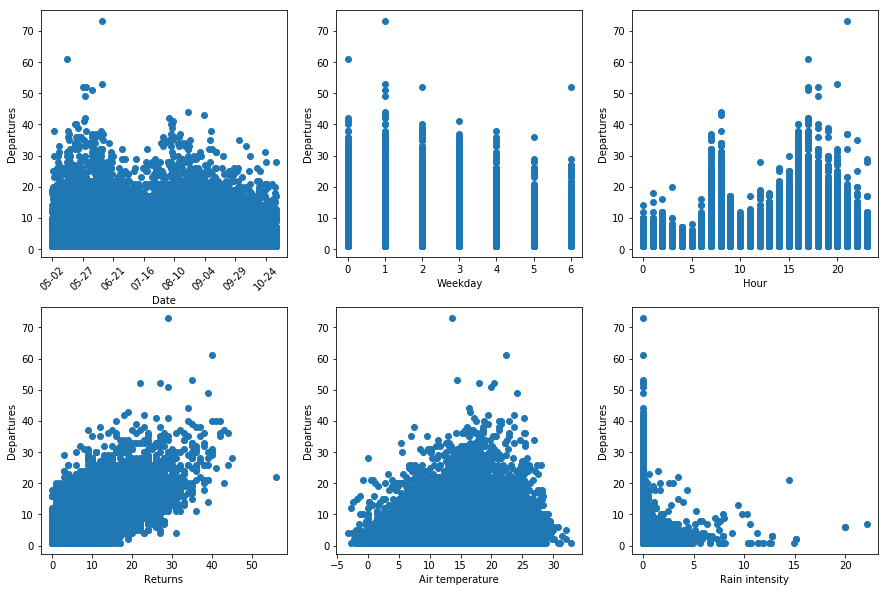

In [4]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures)
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures)
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures)
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures)
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures)
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures)
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()

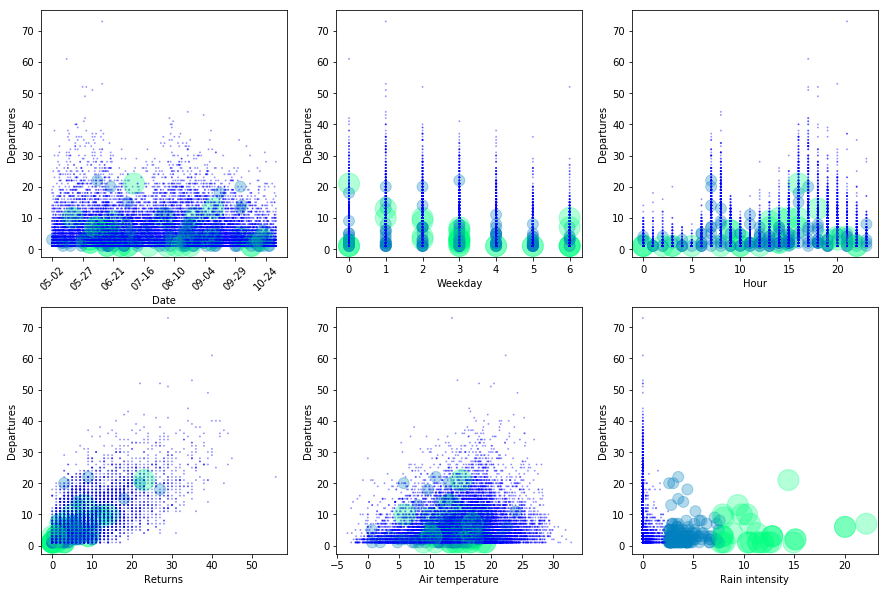

In [5]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()


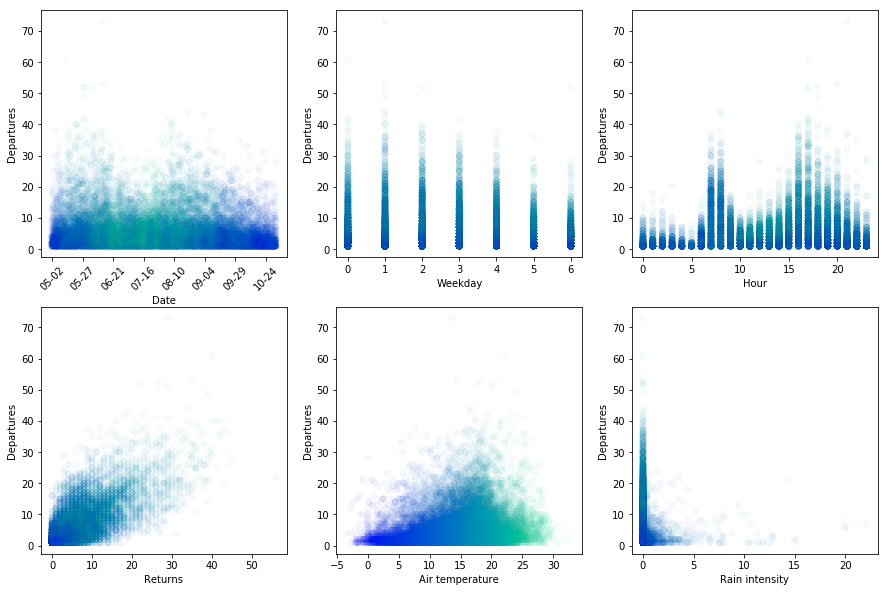

In [6]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()

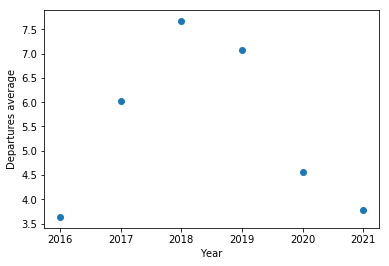

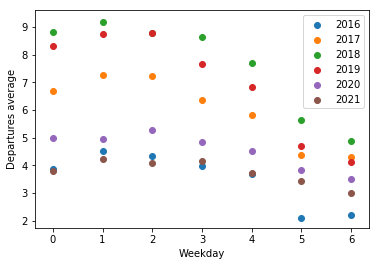

In [7]:
# Cell for investigating the popularity of bikes at Kaisaniemi, depending on year, and weekday on different years

data_grouped_mean = data.groupby(["Year"]).Departures.mean()
year = data_grouped_mean.index.to_numpy()
value = data_grouped_mean[year].values
plt.scatter(year, value)
plt.xlabel("Year")
plt.ylabel("Departures average")
plt.show()

data_grouped_mean = data.groupby(["Year", "Weekday"]).Departures.mean()
for year in range(2016, 2022):
    day = data_grouped_mean[year].index.to_numpy()
    value = data_grouped_mean[year].values
    plt.scatter(day, value, label=year)
plt.xlabel("Weekday")
plt.ylabel("Departures average")
plt.legend()
plt.show()


Let's now plot the departures against the hour of day, for every weekday:

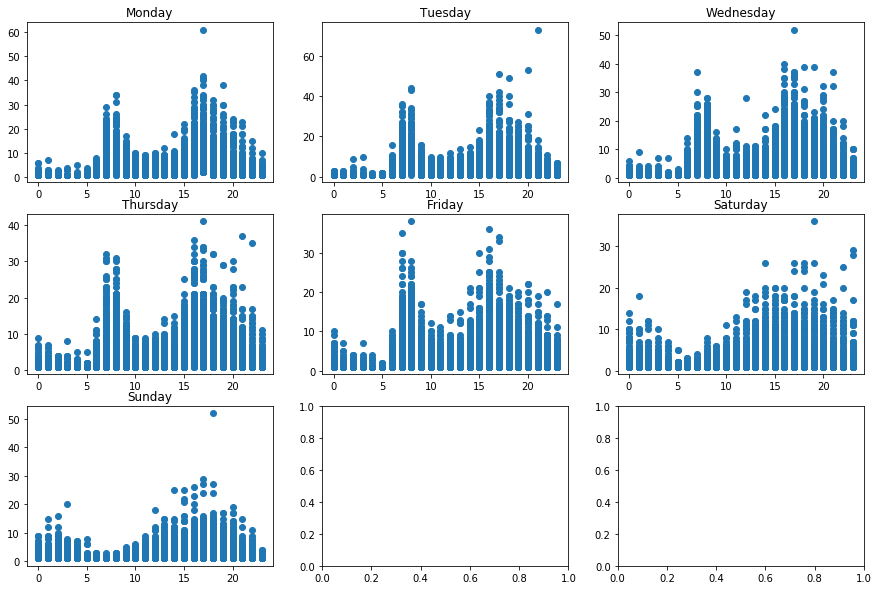

In [8]:
# Separate data into weekday data
data_weekday = [data[data.Weekday == i] for i in range(7)]

# Plot the departures for every hour, for every weekday
fig, axs = plt.subplots(3,3)
fig.set_figwidth(15); fig.set_figheight(10)
j, k = 0, 0
for i in range(7):
    if k==3: k = 0; j += 1
    axs[j, k].scatter(data_weekday[i].Hour, data_weekday[i].Departures)
    axs[j, k].set_title(list(calendar.day_name)[i])
    k+=1
plt.show()


What's interesting to see in the plot above is that we can clearly distuingish rush hours during the weekdays, and what's even more interesting to see is the little bump in departures during the night at the end of the week 😊


Now let's add a categorized value for the number of departures. We'll split the departures into three new ones: 0) Low activity, 1) Medium activity, and 3) High activity, with intervalls of 0-5, 5-15, and >15 departures, respectively.

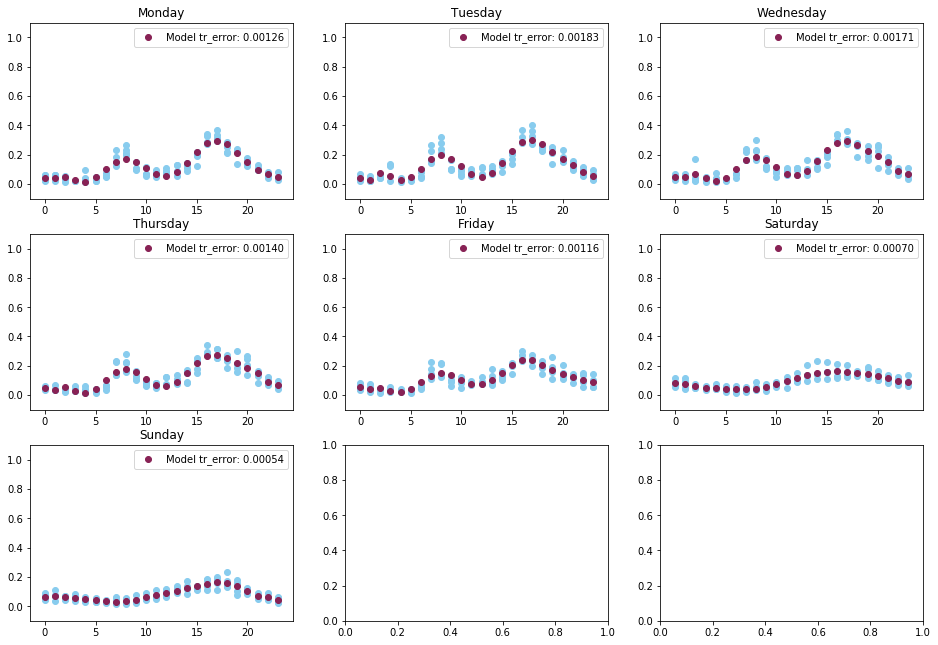

In [9]:
# Polynomial fit for the data where the mean of departure datapoints are taken into account for each hour during each weekday

# Separate data into weekday data
data_weekday = [data[ (data.Weekday == i) & (data.Year>2017) ] for i in range(7)]

fig, axs = plt.subplots(3,3)
fig.set_figwidth(16); fig.set_figheight(11)
j, k = 0, 0

for i in range(7):
    if k==3: k = 0; j += 1
    y = data_weekday[i].groupby(["Hour", "Year"])["Normalized departures"].mean().to_numpy()
    X = data_weekday[i].groupby(["Hour", "Year"])["Normalized departures"].mean().index.get_level_values(0).to_numpy().reshape(-1, 1)

    poly = PolynomialFeatures(degree=10)
    X_poly = poly.fit_transform(X)
    
    lin_regr = LinearRegression(fit_intercept=False)
    lin_regr.fit(X_poly, y)
    
    y_pred = lin_regr.predict(X_poly)
    tr_error = mean_squared_error(y, y_pred)

    X_fit = np.linspace(0, 23, 24)    # generate samples

    axs[j, k].scatter(X, y, color="#88CCEE")
    axs[j, k].set_title(list(calendar.day_name)[i])
    axs[j, k].scatter(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), color="#882255", label="Model tr_error: {:.5f}".format(tr_error))
    axs[j, k].legend()
    axs[j, k].set_ylim(-0.1, 1.1)
    k+=1
plt.show()


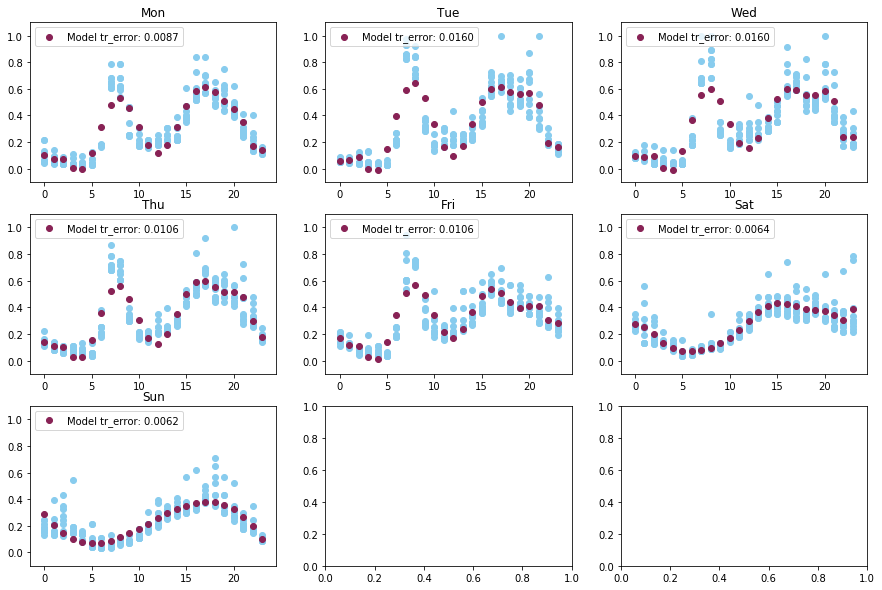

In [10]:
# Polynomial fit for the data where only the 10 max departure datapoints are taken into account for each hour during each weekday

data_largest = data.groupby(["Weekday", "Hour"])["Normalized departures"].nlargest(10)
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
j, k = 0, 0
for day in range(7):
    y = data_largest[day].values.reshape(-1, 1)
    X = data_largest[day].index.get_level_values(0).to_numpy().reshape(-1, 1)

    if day < 6:
        poly = PolynomialFeatures(degree=10)
    else:
        poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)

    lin_regr = LinearRegression(fit_intercept=False)
    lin_regr.fit(X_poly, y)

    y_pred = lin_regr.predict(X_poly)
    tr_error = mean_squared_error(y, y_pred)

    X_fit = np.linspace(0, 23, 24)    # generate samples

    if k == 3:
        k = 0
        j += 1

    axs[j, k].scatter(X, y, color="#88CCEE")
    axs[j, k].set_title(int_to_weekday_map[day])
    axs[j, k].scatter(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), color="#882255", label="Model tr_error: {:.4f}".format(tr_error))
    axs[j, k].legend(loc='upper left')
    axs[j, k].set_ylim(-0.1, 1.1)
    k += 1

plt.show()


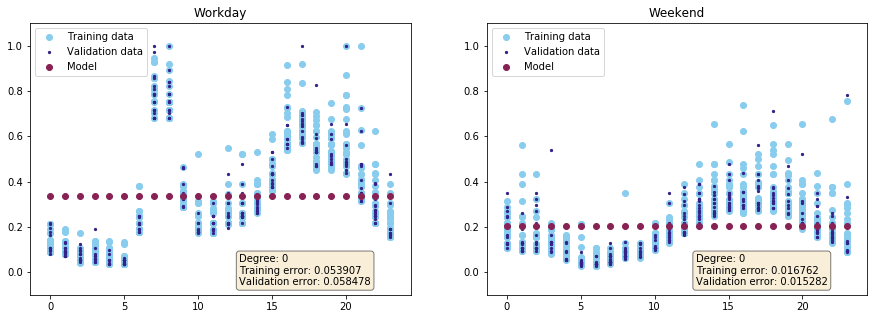

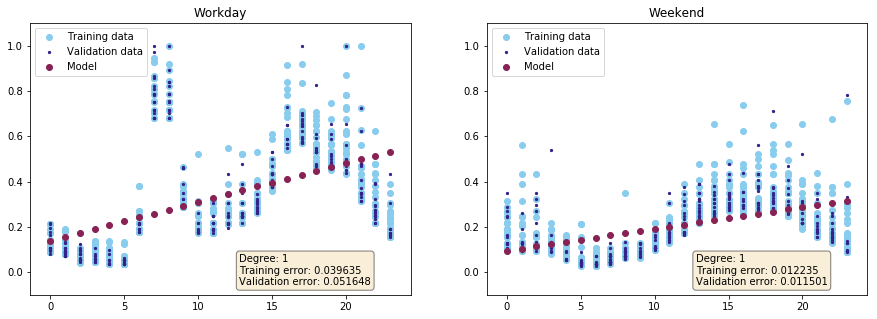

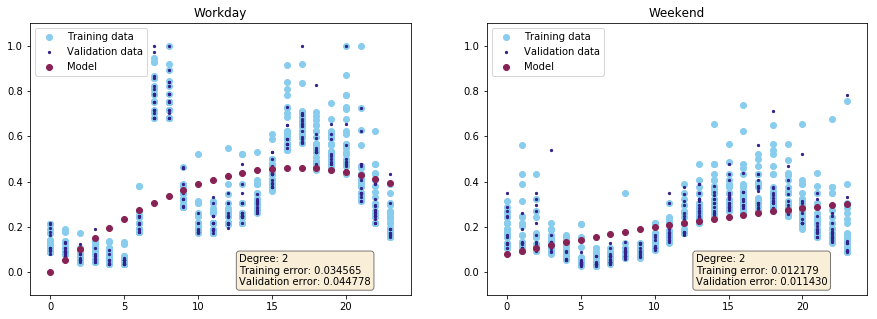

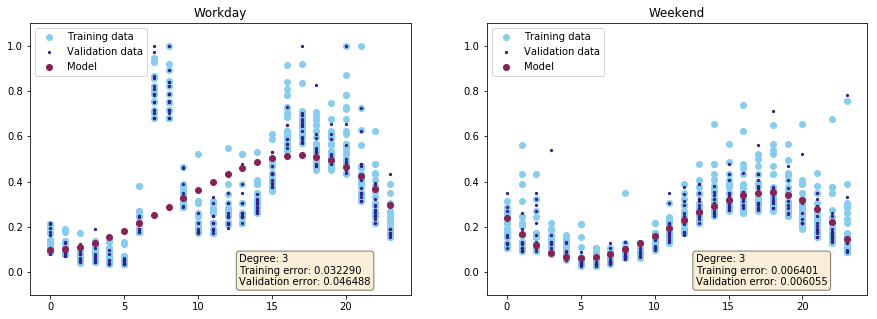

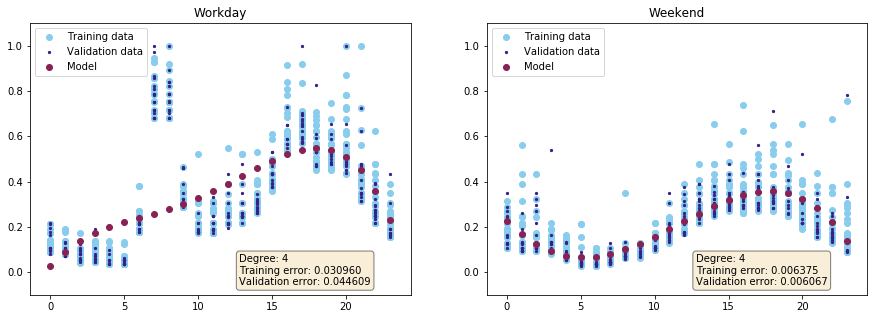

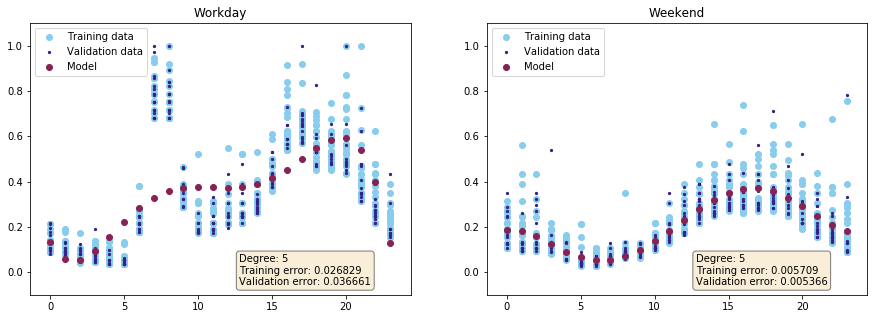

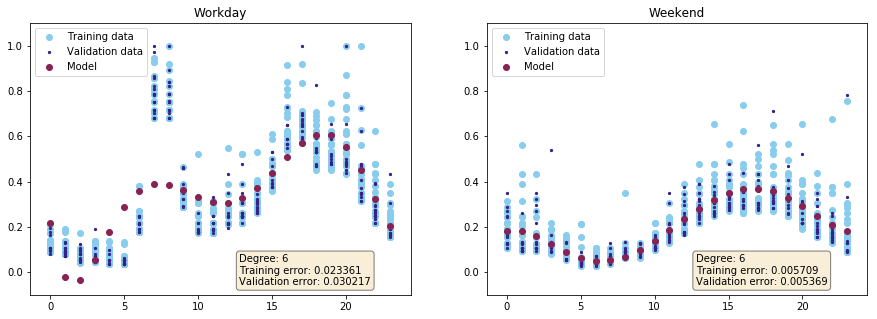

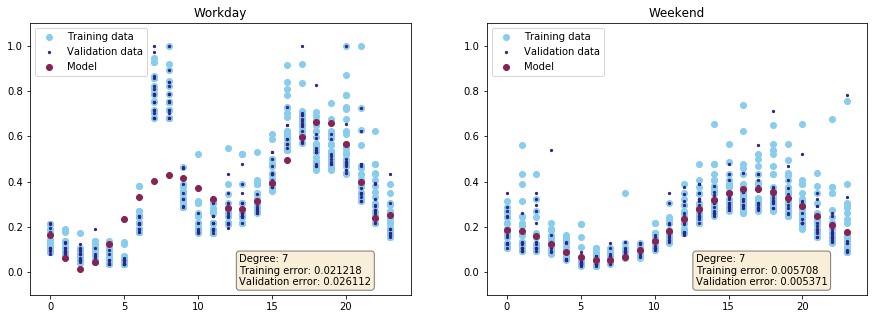

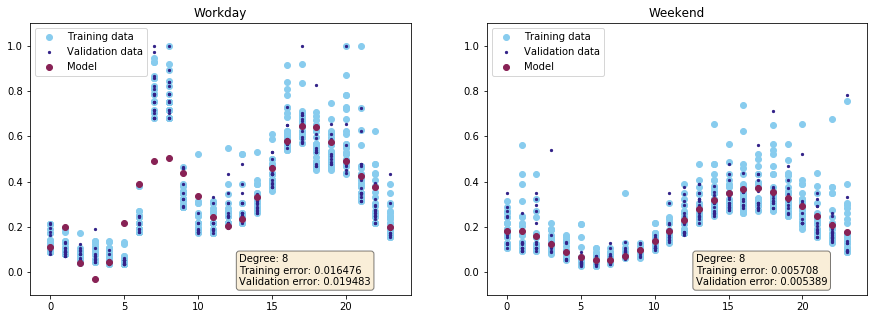

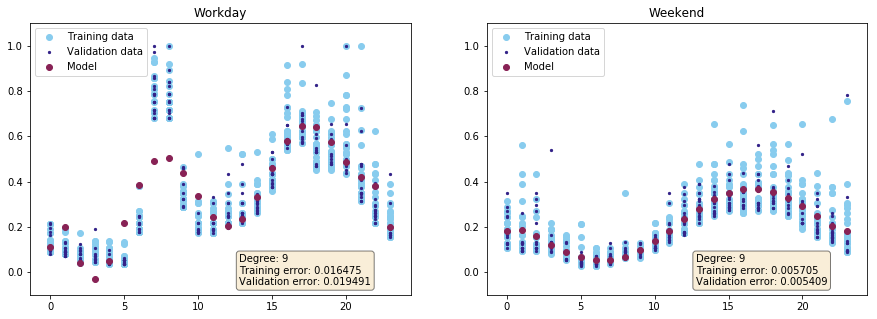

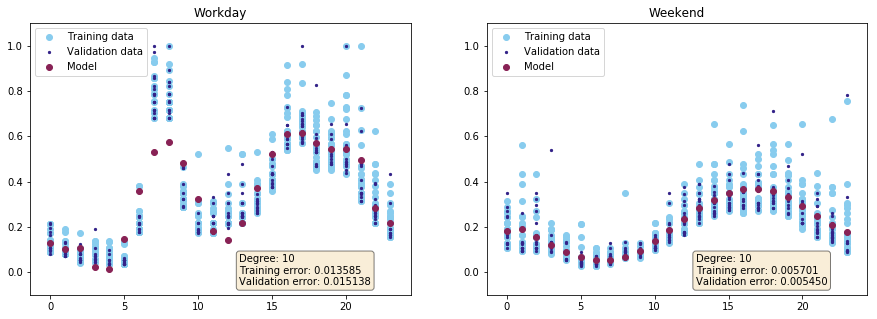

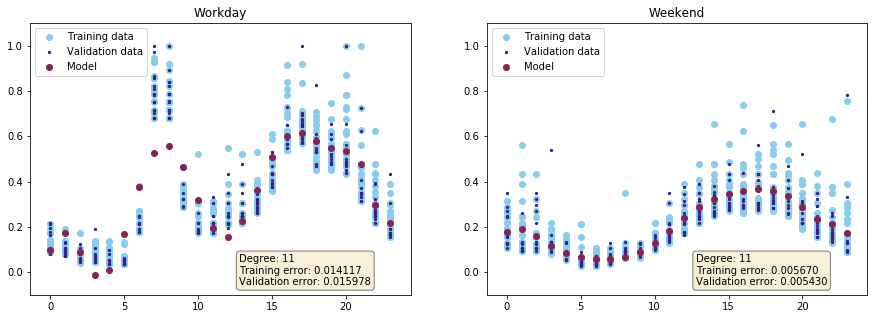

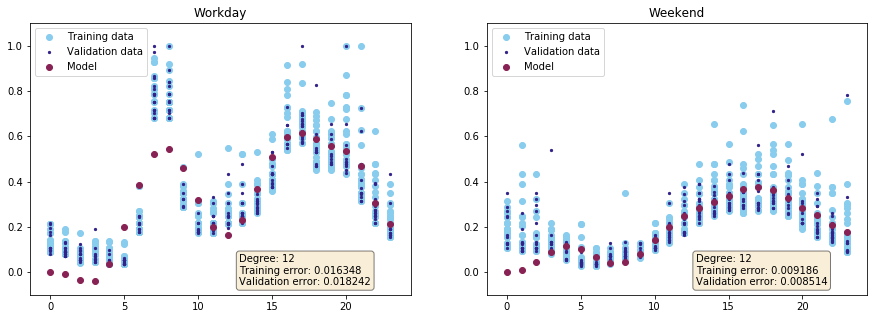

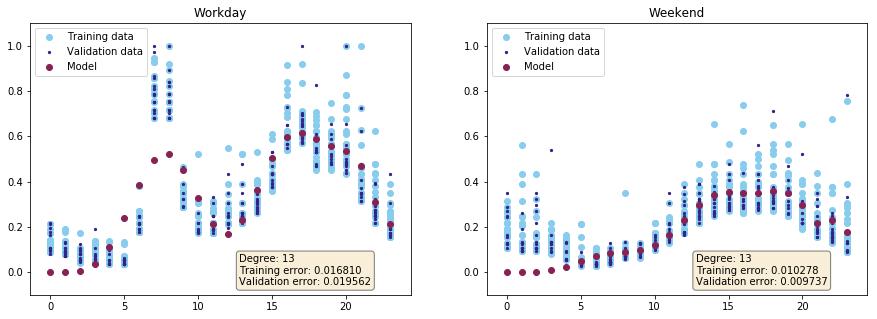

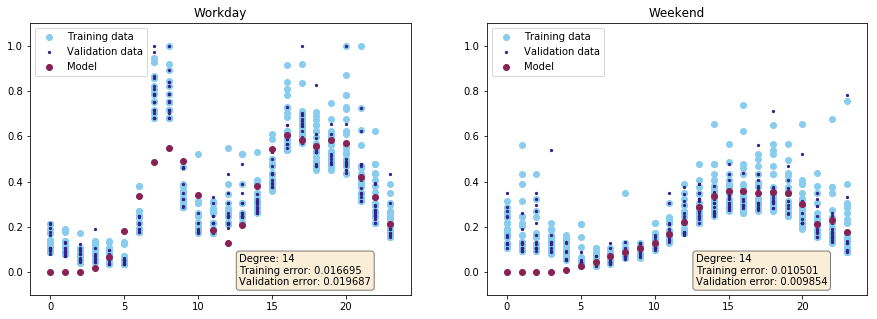

In [11]:
# Do the same thing as above, but split days into two categories: workday and weekend (0 and 1)

# Polynomial fit for the data where only the 10 max departure datapoints are taken into account for each hour during each weekday

data_largest = data.groupby(["Weekday classifier", "Hour"])[
    "Normalized departures"].nlargest(40)

tr_errors = {0 : [], 1 : []}
val_errors = {0: [], 1: []}
for deg in range(0, 15):
    fig, axs = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    for day in range(2):
        y = data_largest[day].values
        X = data_largest[day].index.get_level_values(0).to_numpy().reshape(-1, 1)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
        
        poly = PolynomialFeatures(degree=deg)
        X_train_poly = poly.fit_transform(X_train)

        lin_regr = LinearRegression(fit_intercept=False)
        lin_regr.fit(X_train_poly, y_train)

        y_pred_train = lin_regr.predict(X_train_poly)
        tr_error = mean_squared_error(y_train, y_pred_train)
        tr_errors[day].append(tr_error)

        X_val_poly = poly.fit_transform(X_val)
        y_pred_val = lin_regr.predict(X_val_poly)
        val_error = mean_squared_error(y_val, y_pred_val)
        val_errors[day].append(val_error)

        X_fit = np.linspace(0, 23, 24)    # generate samples

        title = ""
        if day == 0:
            title = "Workday"
        else:
            title = "Weekend"

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        text_str = "Degree: {:d}".format(deg) + "\nTraining error: {:.6f}".format(tr_error) + "\nValidation error: {:.6f}".format(val_error)
        axs[day].text(0.55, 0.15, text_str, transform=axs[day].transAxes, fontsize=10, verticalalignment="top", bbox=props)

        axs[day].scatter(X_train, y_train, color="#88CCEE", label="Training data")
        axs[day].scatter(X_val, y_val, s=5, color="#332288", label="Validation data")
        axs[day].set_title(title)
        axs[day].scatter(X_fit, lin_regr.predict(poly.transform(
            X_fit.reshape(-1, 1))), color="#882255", 
            label="Model")
        axs[day].legend(loc='upper left', prop={'size' : 10})
        axs[day].set_ylim(-0.1, 1.1)

    plt.show()


15 2 2


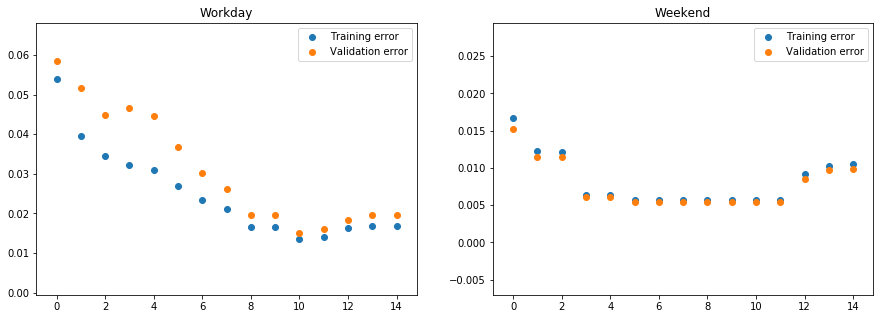

In [12]:
# Plot the training and validation errors

y = [deg for deg in range(15)]
print(len(y), len(tr_errors), len(val_errors))
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)

axs[0].set_title("Workday")
axs[1].set_title("Weekend")
axs[0].scatter(y, tr_errors[0], label="Training error")
axs[0].scatter(y, val_errors[0], label="Validation error")
axs[1].scatter(y, tr_errors[1], label="Training error")
axs[1].scatter(y, val_errors[1], label="Validation error")
axs[0].legend()
axs[1].legend()
plt.show()


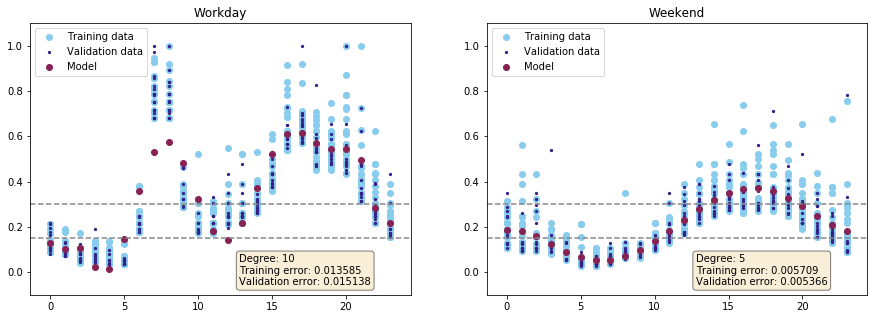

In [13]:
# Do the same thing as above, but split days into two categories: workday and weekend (0 and 1)

# Polynomial fit for the data where only the 10 max departure datapoints are taken into account for each hour during each weekday

data_largest = data.groupby(["Weekday classifier", "Hour"])[
    "Normalized departures"].nlargest(40)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
for day in range(2):
    y = data_largest[day].values
    X = data_largest[day].index.get_level_values(
        0).to_numpy().reshape(-1, 1)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.33, random_state=42)

    title = ""
    if day == 0:
        title = "Workday"
        deg = 10
    else:
        title = "Weekend"
        deg = 5

    poly = PolynomialFeatures(degree=deg)

    X_train_poly = poly.fit_transform(X_train)

    lin_regr = LinearRegression(fit_intercept=False)
    lin_regr.fit(X_train_poly, y_train)

    y_pred_train = lin_regr.predict(X_train_poly)
    tr_error = mean_squared_error(y_train, y_pred_train)

    X_val_poly = poly.fit_transform(X_val)
    y_pred_val = lin_regr.predict(X_val_poly)
    val_error = mean_squared_error(y_val, y_pred_val)

    X_fit = np.linspace(0, 23, 24)    # generate samples

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    text_str = "Degree: {:d}".format(deg) + "\nTraining error: {:.6f}".format(
        tr_error) + "\nValidation error: {:.6f}".format(val_error)
    axs[day].text(0.55, 0.15, text_str, transform=axs[day].transAxes,
                    fontsize=10, verticalalignment="top", bbox=props)

    axs[day].scatter(X_train, y_train, color="#88CCEE",
                        label="Training data")
    axs[day].scatter(X_val, y_val, s=5, color="#332288",
                        label="Validation data")
    axs[day].set_title(title)
    axs[day].scatter(X_fit, lin_regr.predict(poly.transform(
        X_fit.reshape(-1, 1))), color="#882255",
        label="Model")
    axs[day].axhline(y=0.15, color='#888888', linestyle='--')
    axs[day].axhline(y=0.30, color='#888888', linestyle='--')
    axs[day].legend(loc='upper left', prop={'size': 10})
    axs[day].set_ylim(-0.1, 1.1)

plt.show()


In [116]:
# Categorize departures
departure_categories = [0, 1, 2]
cut_bins = [0, 5, 15, 1000]
categorized_departures = pd.cut(data['Departures'], bins=cut_bins, labels=departure_categories, include_lowest=True)

data["Categorized departures"] = categorized_departures
